c:\PythonWorkspace\yasar\Server-RAG\helpers\config.py:11: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3.2")
c:\PythonWorkspace\yasar\Server-RAG\helpers\config.py:12: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory()


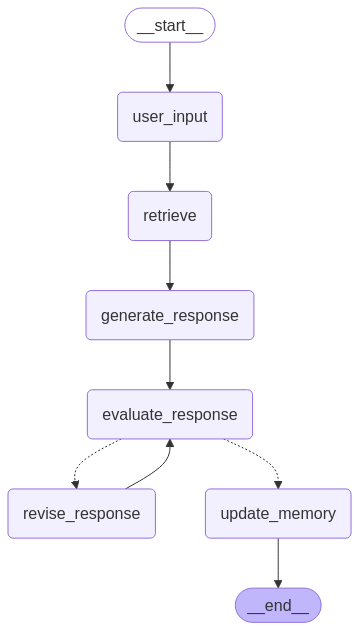

In [ ]:
import gradio as gr
from langgraph.graph import StateGraph, END
from modules.agent_state import AgentState
from modules.nodes import Nodes
from helpers.logger import log_event

THRESHOLD_SCORE = 0.7

def should_continue(state):
        if state["grader_score"] >= THRESHOLD_SCORE:
            log_event("INFO", "Response meets quality threshold. Proceeding to memory update.")
            return "update_memory"
        
        if state["revision_number"] >= state["max_revisions"]:
            log_event("INFO", "Max revisions reached. Proceeding with final response.")
            return "update_memory"
        
        log_event("INFO", "Response needs improvement. Proceeding to revision.")
        return "revise_response"

def build_stategraph():
    builder = StateGraph(AgentState)

    # Düğümleri ekle
    builder.add_node("user_input", Nodes.user_input_node)
    builder.add_node("retrieve", Nodes.retrieve_node)
    builder.add_node("generate_response", Nodes.generate_response_node)
    builder.add_node("evaluate_response", Nodes.evaluate_response_node)
    builder.add_node("revise_response", Nodes.revise_response_node)
    builder.add_node("update_memory", Nodes.update_memory_node)

    # Başlangıç noktası
    builder.set_entry_point("user_input")

    # Akış Bağlantıları
    builder.add_conditional_edges(
        "evaluate_response",
        should_continue,
        {
            "update_memory": "update_memory",
            "revise_response": "revise_response"
        }
    )
    
    builder.add_edge("user_input", "retrieve")
    builder.add_edge("retrieve", "generate_response")
    builder.add_edge("generate_response", "evaluate_response")
    
    builder.add_edge("revise_response", "evaluate_response")
    builder.add_edge("update_memory", END)
    return builder.compile()

rag_graph = build_stategraph()

from IPython.display import Image, display

display(Image(rag_graph.get_graph().draw_mermaid_png()))
 
 


In [ ]:

def respond(message, history):
    final_state = rag_graph.invoke({
        "user_query": message, 
        "max_revisions": 2,
        "revision_number": 1,})
    ai_response = final_state.get("response", "I don't have an answer for that.")
    return ai_response

demo = gr.ChatInterface(
    fn=respond,
    title="IZTECH Telecom RAG Assistant 🤖",
    theme=gr.themes.Soft()
)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


2025/03/01 23:53:56 [W] [service.go:132] login to server failed: i/o deadline reached


Grader Output: Here are the key differences between RRC Idle and RRC Inactive states with scores:

**Power Management (0.8/1)**
In both states, power management is crucial to minimize energy consumption. However, RRC Idle uses reduced transmission power more aggressively to save energy. Score: 0.9
RRC Inactive still conserves power but allows for more resources to be available when re-establishing the connection.

**No Active Communication (1/1)**
In both states, there is no ongoing data transmission or reception of RRC messages. This score is 1 since it's a fundamental characteristic of both states.

**Random Access (0.4/1)**
RRC Idle allows for random access procedures to be initiated if needed, while RRC Inactive does not have this capability. Score: 0.6
This score reflects the limitation in RRC Inactive.

**Cell Selection (0.8/1)**
In both states, cell selection is possible when a suitable cell becomes available. However, RRC Idle may require more time to select a new cell due to p